I wanna sanity test that tabulating the HODs from two different SHAMs will give different clustering. 

In [16]:
import numpy as np
import astropy
from itertools import izip
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from pearce.mocks.customHODModels import *
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [18]:
mag_cut = -21
min_ptcl = 200

In [19]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')
catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [20]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)

In [21]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [22]:
vpeak_catalog = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog['halo_vpeak_mag'] <=mag_cut)]
mpeak_catalog = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog['halo_vvir_mag'] <=mag_cut)]

In [23]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

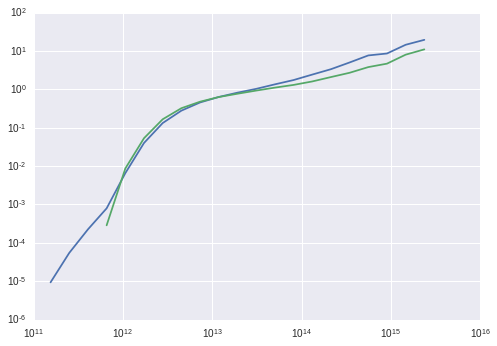

In [24]:
halo_mass = catalog['halo_mvir'][catalog['halo_mvir'] > min_ptcl*cat.pmass]
haloprop_bins = compute_mass_bins(halo_mass, 0.2)
mbc = (haloprop_bins[1:]+haloprop_bins[:-1])/2.0
cen_hods, sat_hods = [], []

for galaxy_catalog in (vpeak_catalog, mpeak_catalog):
    cenmask = galaxy_catalog['halo_upid']==-1
    satmask = galaxy_catalog['halo_upid']>0
    
    cen_hods.append(hod_from_mock(galaxy_catalog['halo_mvir_host_halo'][cenmask], halo_mass, haloprop_bins)[0])
    sat_hods.append(hod_from_mock(galaxy_catalog['halo_mvir_host_halo'][satmask], halo_mass, haloprop_bins)[0])

    plt.plot(mbc, cen_hods[-1]+ sat_hods[-1])
    plt.loglog()

In [25]:
from pearce.mocks.customHODModels import *

In [26]:
#rp_bins = np.logspace(-1,1.5,20)
rp_bins = np.logspace(-1.1,1.6, 18)
bin_centers = (rp_bins[:1]+rp_bins[:-1])/2

In [ ]:
for cen_hod, sat_hod in zip(cen_hods, sat_hods):
    print cen_hod
    print sat_hod
    cat.load_model(1.0, HOD=(TabulatedCens, TabulatedSats), hod_kwargs = {'prim_haloprop_vals': mbc,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':cen_hod,
                                                               'sat_hod_vals':sat_hod})# ,
                                                                #'split':0.7})
        
    cat.populated_once = False
    cat.populate({})
    xi = cat.calc_xi(rp_bins)
    print xi
    break
    
    plt.plot(bin_centers,xi)
    plt.loglog();

[  9.29947086e-06   5.44534648e-05   2.23620048e-04   7.78927275e-04
   6.52298174e-03   3.98616437e-02   1.31518237e-01   2.73696459e-01
   4.36069787e-01   5.82144250e-01   6.92182410e-01   7.84337594e-01
   8.64299065e-01   9.01381910e-01   9.47815534e-01   9.79591837e-01
   9.76878613e-01   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.09708067e-05
   8.40590431e-06   6.47735517e-05   6.16522811e-04   4.30844707e-03
   1.83858054e-02   4.95126706e-02   1.26284139e-01   2.43862853e-01
   4.83364486e-01   8.41708543e-01   1.47330097e+00   2.36479592e+00
   4.03468208e+00   6.64406780e+00   7.58333333e+00   1.35000000e+01
   1.85000000e+01]


In [ ]:
from halotools.mock_observables import wp, tpcf

In [ ]:
min_logmass, max_logmass = 9.0, 17.0

In [ ]:
from halotools.mock_observables import tpcf_one_two_halo_decomp

In [ ]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 0.0, 0.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_no_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_no_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_no_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [ ]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
#MAP = np.array([ 0.38800666, -0.49540832, 3, 3])
MAP = np.array([1.0, -1.0, 5.0, 3.0])

params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [ ]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 1.0, -1.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)

    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_max_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_max_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_max_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [ ]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 1.0, 0.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)

    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_max_cen_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_max_cen_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_max_cen_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [ ]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 0.0, -1.0,5,5])

names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

mock_wps = []
mock_wps_1h, mock_wps_2h = [],[]
mock_nds = []
for i in xrange(10):
    cat.populate(params)
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)

    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table[mass_cut]['x'],\
                     cat.model.mock.galaxy_table[mass_cut]['y'],\
                     cat.model.mock.galaxy_table[mass_cut]['z']]
    mock_wps.append(tpcf(mock_pos, rp_bins , period=cat.Lbox, num_threads=1))
    oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
                                          rp_bins , period=cat.Lbox, num_threads=1)
    mock_wps_1h.append(oneh)
    mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
mock_wp_max_sat_ab = np.mean(mock_wps, axis = 0)
wp_errs = np.std(mock_wps, axis = 0)

mock_wps_1h = np.array(mock_wps_1h)
mock_wp_max_sat_ab_1h = np.mean(mock_wps_1h, axis = 0)

mock_wps_2h = np.array(mock_wps_2h)
mock_wp_max_sat_ab_2h = np.mean(mock_wps_2h, axis = 0)

mock_nds = np.array(mock_nds)
mock_nd = np.mean(mock_nds)
nd_err = np.std(mock_nds)

In [ ]:
catalog.colnames

In [ ]:
#catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')
#halo_catalog_orig = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog['halo_vpeak_mag'] <=mag_cut)]
#halo_catalog_orig = catalog[np.logical_and( \
#                       np.logical_and(catalog['halo_shuffled_host_mvir'] > 10**min_logmass,\
#                                      catalog['halo_shuffled_host_mvir'] < 10**max_logmass),\
#                        catalog['halo_vvir_mag'] <=mag_cut)]

mag_cut = catalog['halo_%s_mag'%mag_type] <=mag_cut
cut_idx = catalog['halo_upid'] >= -1
mass_cut = np.logical_and(np.log10(catalog['halo_mvir_host_halo']) > min_logmass,\
                          np.log10(catalog['halo_mvir_host_halo']) <= max_logmass)
mass_cut = np.logical_and(mass_cut, cut_idx)

halo_catalog_orig = catalog[np.logical_and(mag_cut, mass_cut)]

In [ ]:
print len(halo_catalog_orig)

In [ ]:
centrals_idx = np.where(halo_catalog_orig['halo_upid']>=-1)[0]

sham_pos = np.c_[halo_catalog_orig['halo_x'],\
                 halo_catalog_orig['halo_y'],\
                 halo_catalog_orig['halo_z']]
sham_wp = tpcf(sham_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
print sham_wp

In [ ]:
host_ids = halo_catalog_orig['halo_upid']
host_ids[centrals_idx] = halo_catalog_orig[centrals_idx]['halo_id']
sham_wp_1h, sham_wp_2h = tpcf_one_two_halo_decomp(sham_pos,host_ids, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
#sham_nd = len(halo_catalog_orig[centrals_idx])/(cat.Lbox**3)
sham_nd = len(halo_catalog_orig)/(cat.Lbox**3)

In [ ]:
sham_nfw_pos = np.c_[halo_catalog_orig['halo_nfw_x'],\
                 halo_catalog_orig['halo_nfw_y'],\
                 halo_catalog_orig['halo_nfw_z']]

sham_nfw_wp = tpcf(sham_nfw_pos, rp_bins, period=cat.Lbox, num_threads=1)

In [ ]:
sham_nfw_wp_1h, sham_nfw_wp_2h = tpcf_one_two_halo_decomp(sham_nfw_pos,host_ids,\
                                                          rp_bins, period=cat.Lbox, num_threads=1)

In [ ]:
halo_catalog.colnames

In [ ]:
shuffle_type = 'shuffled'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)

sham_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[ma ss_cut]['halo_%s_z'%shuffle_type]]
sham_shuffled_wp = tpcf(sham_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_shuffled_wp_1h, sham_shuffled_wp_2h = tpcf_one_two_halo_decomp(sham_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
shuffle_type = 'sh_shuffled'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)
sham_sh_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_z'%shuffle_type]]
sham_sh_shuffled_wp = tpcf(sham_sh_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_sh_shuffled_wp_1h, sham_sh_shuffled_wp_2h = tpcf_one_two_halo_decomp(sham_sh_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
shuffle_type = 'sh_shuffled_cen'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)
sham_sh_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_z'%shuffle_type]]
sham_sh_shuffled_cen_wp = tpcf(sham_sh_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_sh_shuffled_cen_wp_1h, sham_sh_shuffled_cen_wp_2h = tpcf_one_two_halo_decomp(sham_sh_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
shuffle_type = 'sh_shuffled_sats'
mass_cut = np.logical_and(np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) > min_logmass,\
                          np.log10(halo_catalog['halo_%s_host_mvir'%shuffle_type]) < max_logmass)
cut_idx = halo_catalog['halo_%s_upid'%shuffle_type] >= -1
mass_cut = np.logical_and(mass_cut, cut_idx)
sham_sh_shuffled_pos = np.c_[halo_catalog[mass_cut]['halo_%s_x'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_y'%shuffle_type],\
                          halo_catalog[mass_cut]['halo_%s_z'%shuffle_type]]
sham_sh_shuffled_sat_wp = tpcf(sham_sh_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
centrals_idx = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]>=-1

host_ids = halo_catalog[mass_cut]['halo_%s_upid'%shuffle_type]
host_ids[centrals_idx] = halo_catalog[mass_cut][centrals_idx]['halo_id']
sham_sh_shuffled_sat_wp_1h, sham_sh_shuffled_sat_wp_2h = tpcf_one_two_halo_decomp(sham_sh_shuffled_pos, host_ids,\
                                    rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
#shuffled_nd = len(cut_idx)/(cat.Lbox**3)
shuffled_nd = len(halo_catalog)/(cat.Lbox**3)

In [ ]:
print sham_nd,shuffled_nd, mock_nd
print sham_nd-mock_nd, nd_err
print (sham_nd-mock_nd)/nd_err

In [ ]:
plt.figure(figsize=(10,8))
plt.errorbar(bin_centers, mock_wp_no_ab,yerr=wp_errs, label = 'no ab model')
plt.errorbar(bin_centers, mock_wp_ab,yerr=wp_errs, label = 'ab model')
plt.errorbar(bin_centers, mock_wp_max_ab,yerr=wp_errs, label = 'max model')
plt.plot(bin_centers, sham_wp, label = 'sham')
plt.plot(bin_centers, sham_nfw_wp, label = 'nfw-ized sham')
plt.plot(bin_centers, sham_shuffled_wp, label = 'shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_wp, label = 'sh shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_cen_wp, label = 'sh shuffled cen & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_sat_wp, label = 'sh shuffled sat & nfw-ized sham')


plt.loglog()
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ comparison for HOD+AB and NFW-ized SHAM', fontsize = 20)

In [ ]:
print sham_sh_shuffled_wp_2h/sham_shuffled_wp_2h

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(bin_centers, mock_wp_no_ab_2h, label = 'no ab model')
plt.plot(bin_centers, mock_wp_ab_2h, label = 'ab model')
plt.plot(bin_centers, mock_wp_max_ab_2h, label = 'max model')

plt.plot(bin_centers, sham_wp_2h, label = 'sham')
plt.plot(bin_centers, sham_nfw_wp_2h, label = 'nfw-ized sham')
plt.plot(bin_centers, sham_shuffled_wp_2h, label = 'shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_wp_2h, label = 'sh shuffled & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_cen_wp_2h, label = 'sh shuffled cen & nfw-ized sham')
plt.plot(bin_centers, sham_sh_shuffled_sat_wp_2h, label = 'sh shuffled sat & nfw-ized sham')

plt.loglog()
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ comparison for HOD+AB and NFW-ized SHAM', fontsize = 20)

In [ ]:
%%bash
ls *xi*.npy

In [ ]:
np.savetxt('mock_xi_%s.npy'%mag_type,mock_wp_no_ab)
np.savetxt('mock_xi_ab_%s.npy'%mag_type,mock_wp_ab)
np.savetxt('mock_xi_max_ab_%s.npy'%mag_type,mock_wp_max_ab)
np.savetxt('mock_xi_max_cen_ab_%s.npy'%mag_type,mock_wp_max_cen_ab)
np.savetxt('mock_xi_max_sat_ab_%s.npy'%mag_type,mock_wp_max_sat_ab)
np.savetxt('sham_xi_%s.npy'%mag_type, sham_wp)
np.savetxt('sham_shuffle_xi_%s.npy'%(mag_type), sham_shuffled_wp)
np.savetxt('sham_sh_shuffle_xi_%s.npy'%(mag_type), sham_sh_shuffled_wp)
np.savetxt('sham_nfw_xi_%s.npy'%mag_type, sham_nfw_wp)
np.savetxt('sham_sh_shuffle_cen_xi_%s.npy'%(mag_type), sham_sh_shuffled_cen_wp)
np.savetxt('sham_sh_shuffle_sat_xi_%s.npy'%(mag_type), sham_sh_shuffled_sat_wp)

In [ ]:
np.savetxt('mock_xi_%s_1h.npy'%mag_type,mock_wp_no_ab_1h)
np.savetxt('mock_xi_ab_%s_1h.npy'%mag_type,mock_wp_ab_1h)
np.savetxt('mock_xi_max_ab_%s_1h.npy'%mag_type,mock_wp_max_ab_1h)
np.savetxt('mock_xi_max_cen_ab_%s_1h.npy'%mag_type,mock_wp_max_cen_ab_1h)
np.savetxt('mock_xi_max_sat_ab_%s_1h.npy'%mag_type,mock_wp_max_sat_ab_1h)
np.savetxt('sham_xi_%s_1h.npy'%mag_type, sham_wp_1h)
np.savetxt('sham_shuffle_xi_%s_1h.npy'%(mag_type), sham_shuffled_wp_1h)
np.savetxt('sham_sh_shuffle_xi_%s_1h.npy'%(mag_type), sham_sh_shuffled_wp_1h)
np.savetxt('sham_nfw_xi_%s_1h.npy'%mag_type, sham_nfw_wp_1h)
np.savetxt('sham_sh_shuffle_cen_xi_%s_1h.npy'%(mag_type), sham_sh_shuffled_cen_wp_1h)
np.savetxt('sham_sh_shuffle_sat_xi_%s_1h.npy'%(mag_type), sham_sh_shuffled_sat_wp_1h)

In [ ]:
np.savetxt('mock_xi_%s_2h.npy'%mag_type,mock_wp_no_ab_2h)
np.savetxt('mock_xi_ab_%s_2h.npy'%mag_type,mock_wp_ab_2h)
np.savetxt('mock_xi_max_ab_%s_2h.npy'%mag_type,mock_wp_max_ab_2h)
np.savetxt('mock_xi_max_cen_ab_%s_2h.npy'%mag_type,mock_wp_max_cen_ab_2h)
np.savetxt('mock_xi_max_sat_ab_%s_2h.npy'%mag_type,mock_wp_max_sat_ab_2h)
np.savetxt('sham_xi_%s_2h.npy'%mag_type, sham_wp_2h)
np.savetxt('sham_shuffle_xi_%s_2h.npy'%(mag_type), sham_shuffled_wp_2h)
np.savetxt('sham_sh_shuffle_xi_%s_2h.npy'%(mag_type), sham_sh_shuffled_wp_2h)
np.savetxt('sham_nfw_xi_%s_2h.npy'%mag_type, sham_nfw_wp_2h)
np.savetxt('sham_sh_shuffle_cen_xi_%s_2h.npy'%(mag_type), sham_sh_shuffled_cen_wp_2h)
np.savetxt('sham_sh_shuffle_sat_xi_%s_2h.npy'%(mag_type), sham_sh_shuffled_sat_wp_2h)

In [ ]:
plt.figure(figsize=(10,8))
plt.errorbar(bin_centers, mock_wp/mock_wp,yerr=wp_errs/mock_wp, label = 'model/model')
plt.plot(bin_centers, sham_wp/mock_wp, label = 'sham/model')
plt.plot(bin_centers, sham_nfw_wp/mock_wp, label = 'nfw-ized sham/model')
plt.plot(bin_centers, sham_shuffled_wp/mock_wp, label = 'shuffled & nfw-ized sham/model')
plt.xscale('log')
plt.legend(loc='best')
plt.xlim([1e-1, 5e0]);
#plt.ylim([0.8,1.2]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w_{SHAM}(r_p)/w_{HOD+AB}(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ ratio for HOD+AB and NFW-ized SHAM', fontsize = 20)

In [ ]:
print mock_wps/sham_shuffled_wp

In [ ]:
colors = sns.color_palette("coolwarm", ab_vals.shape[0])

In [ ]:
plt.figure(figsize=(10,8))
#plt.errorbar(bin_centers, mock_wp/sham_shuffled_wp,yerr=wp_errs/mock_wp, label = 'model/model')
for mwp, a, c in zip(mock_wps, ab_vals, colors):
    plt.plot(bin_centers,mwp/sham_shuffled_wp, c =c, label = a)
plt.plot(bin_centers, sham_wp/sham_shuffled_wp, label = 'sham/model')
plt.plot(bin_centers, sham_nfw_wp/sham_shuffled_wp, label = 'nfw-ized sham/model')
plt.plot(bin_centers, sham_shuffled_wp/sham_shuffled_wp, label = 'shuffled & nfw-ized sham/model')
plt.xscale('log')
plt.legend(loc='best')
plt.xlim([1e-1, 5e0]);
#plt.ylim([0.8,1.2]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w_{SHAM}(r_p)/w_{HOD+AB}(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ ratio for HOD+AB and NFW-ized SHAM', fontsize = 20)